# Traffic Sign Classification

In [12]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import random
from sklearn.utils import shuffle

## Load Data

In [2]:
training_file = '../data/train.p'
validation_file='../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print(X_train.shape)

(34799, 32, 32, 3)


## Dataset Exploration

In [3]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
signs = pd.read_csv("./signnames.csv")
n_classes = signs['ClassId'].count()

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


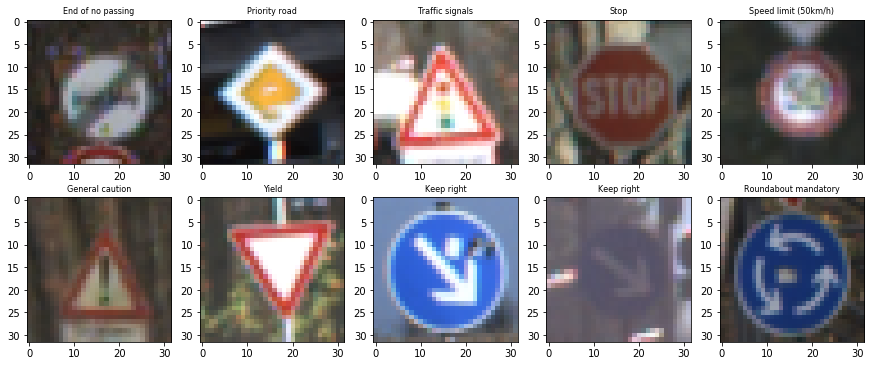

In [4]:
# Randomly visualize 10 training images
fig, ax = plt.subplots(2,5, figsize=(15, 6))

#fig.subplots_adjust(hspace = .2, wspace=.001)
for i in range(10):
    index = random.randint(0,len(X_train)-1)
    img = X_train[index]
    ax_index = (int(np.floor(i/5)),i%5)
    ax[ax_index].imshow(img)
    ax[ax_index].set_title(signs['SignName'][y_train[index]],fontsize=8)
plt.savefig('./output/examples.jpg',bbox_inches = 'tight', pad_inches = 0)

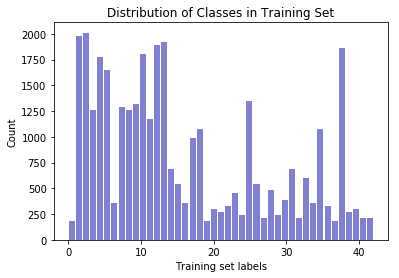

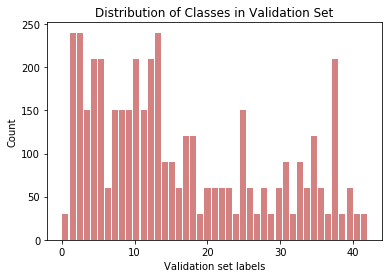

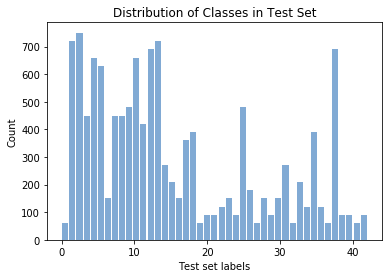

In [5]:
plt.hist(y_train,bins=n_classes,color='#0504aa', alpha=0.5, rwidth=0.85)
plt.xlabel('Training set labels')
plt.ylabel('Count')
plt.title('Distribution of Classes in Training Set')
plt.savefig('./output/training_hist.jpg',bbox_inches = 'tight', pad_inches = 0)
plt.show()

plt.hist(y_valid,bins=n_classes,color='#aa0504', alpha=0.5, rwidth=0.85)
plt.xlabel('Validation set labels')
plt.ylabel('Count')
plt.title('Distribution of Classes in Validation Set')
plt.savefig('./output/valid_hist.jpg',bbox_inches = 'tight', pad_inches = 0)
plt.show()

plt.hist(y_test,bins=n_classes,color='#0456aa', alpha=0.5, rwidth=0.85)
plt.xlabel('Test set labels')
plt.ylabel('Count')
plt.title('Distribution of Classes in Test Set')
plt.savefig('./output/test_hist.jpg',bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Design and Test a Model Architecture

### Normalization

In [6]:
# Normalization
# Convert to grayscale
X_train_gray = np.mean(X_train,axis=-1).reshape(-1,32,32,1)
X_valid_gray = np.mean(X_valid,axis=-1).reshape(-1,32,32,1)
# Normalize: zero mean and equal variance
X_train_normalized = X_train_gray/255
print("X_train mean: {:04.3f}\nX_train_normalized mean: {:04.3f}".format(
    np.mean(X_train),np.mean(X_train_normalized)))

X_valid_normalized = X_valid_gray/255
print("X_valid mean: {:04.3f}\nX_valid_normalized mean: {:04.3f}".format(
    np.mean(X_valid),np.mean(X_valid_normalized)))

X_train mean: 82.678
X_train_normalized mean: 0.324
X_valid mean: 83.556
X_valid_normalized mean: 0.328


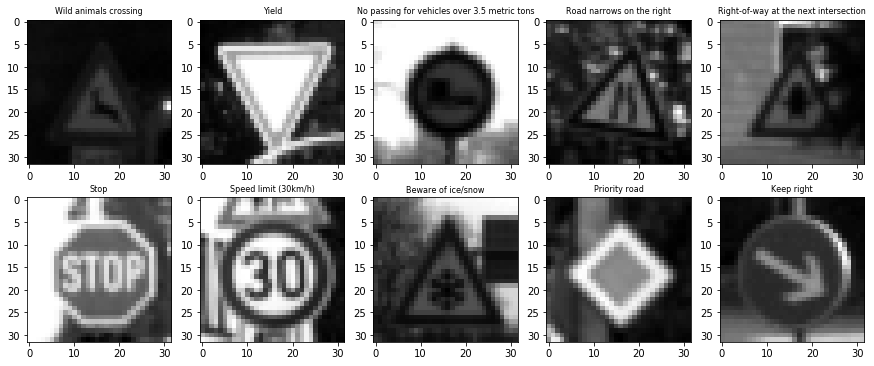

In [7]:
#Visualize
# Randomly visualize 10 normalized training images
fig, ax = plt.subplots(2,5, figsize=(15, 6))

#fig.subplots_adjust(hspace = .2, wspace=.001)
for i in range(10):
    index = random.randint(0,len(X_valid_normalized)-1)
    img = X_valid_normalized[index]
    ax_index = (int(np.floor(i/5)),i%5)
    ax[ax_index].imshow(img.squeeze(),cmap='gray')
    ax[ax_index].set_title(signs['SignName'][y_valid[index]],fontsize=8)
plt.savefig('./output/normalized.jpg',bbox_inches = 'tight', pad_inches = 0)

### Model Architecture

In [8]:
from tensorflow.contrib.layers import flatten
EPOCHS = 20
BATCH_SIZE = 128

def LeNet_mod(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='conv1')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 10x10x16 Output = 5x5x16 
    conv2 = tf.nn.max_pool(conv2,ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID',name='conv2')
    
    # Layer 3: Convolutional. Output = 3x3x256
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3,3,16,256),mean=mu,stddev=sigma))
    conv3_b = tf.Variable(tf.zeros(256))
    conv3 = tf.nn.conv2d(conv2,conv3_W,strides=[1,1,1,1], padding='VALID') + conv3_b
    
    # Pooling. Input = 3x3x256. Output = 2x2x256.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID',name='conv3')

    # Flatten. Input = 2x2x256. Output = 1024.
    fc0   = flatten(conv3)
    
    # Dropout
    fc0 = tf.nn.dropout(fc0,keep_prob,name='fc0')
    
    # Layer 4: Fully Connected. Input = 1024. Output = 400.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1024, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1,keep_prob,name='fc1')

    # Layer 5: Fully Connected. Input = 400. Output = 120.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(400, n_classes), mean = mu, stddev = sigma),name='fc2_weights')
    fc2_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    
    return logits

In [9]:
tf.reset_default_graph() 

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units
one_hot_y = tf.one_hot(y, n_classes)

### Train, Validate, Test Model

In [10]:
rate = 0.001
logits = LeNet_mod(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_normalized)
    
    print("Training...")
    print()
    
    for i in range(EPOCHS):
        X_train_normalized, y_train = shuffle(X_train_normalized, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_normalized[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid_normalized, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet_mod')
    print("Model saved")


Training...

EPOCH 1 ...
Validation Accuracy = 0.805

EPOCH 2 ...
Validation Accuracy = 0.908

EPOCH 3 ...
Validation Accuracy = 0.926

EPOCH 4 ...
Validation Accuracy = 0.932

EPOCH 5 ...
Validation Accuracy = 0.929

EPOCH 6 ...
Validation Accuracy = 0.941

EPOCH 7 ...
Validation Accuracy = 0.947

EPOCH 8 ...
Validation Accuracy = 0.951

EPOCH 9 ...
Validation Accuracy = 0.950

EPOCH 10 ...
Validation Accuracy = 0.950

EPOCH 11 ...
Validation Accuracy = 0.963

EPOCH 12 ...
Validation Accuracy = 0.954

EPOCH 13 ...
Validation Accuracy = 0.950

EPOCH 14 ...
Validation Accuracy = 0.946

EPOCH 15 ...
Validation Accuracy = 0.962

EPOCH 16 ...
Validation Accuracy = 0.966

EPOCH 17 ...
Validation Accuracy = 0.953

EPOCH 18 ...
Validation Accuracy = 0.953

EPOCH 19 ...
Validation Accuracy = 0.961

EPOCH 20 ...
Validation Accuracy = 0.962

Model saved


In [14]:
# Test set accuracy
X_test_gray = np.mean(X_test,axis=-1).reshape(-1,32,32,1)
X_test_normalized = X_test_gray/255
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    graph_import = tf.train.import_meta_graph('./lenet_mod.meta')
    graph_import.restore(sess, "./lenet_mod")
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet_mod
Test Set Accuracy = 0.942


## Test Model on New Images

In [21]:
# Load images and process them to be 32x32 array
import glob
import cv2
import matplotlib.image as mpimg
from PIL import Image
new_images = glob.glob('./new_images/*.jpg')
new_images.extend(glob.glob('./new_images/*.jpeg'))
X_new = np.zeros((len(new_images),32,32,3))

for i, fname in enumerate(new_images):
    img = mpimg.imread(fname)
    img = cv2.resize(img, (32, 32))
    X_new[i]=img

y_new_labels = np.array([4,23,27,17,25])
print('New image labels: ',y_new_labels)

New image labels:  [ 4 23 27 17 25]


X_new_gray: (5, 32, 32, 1)



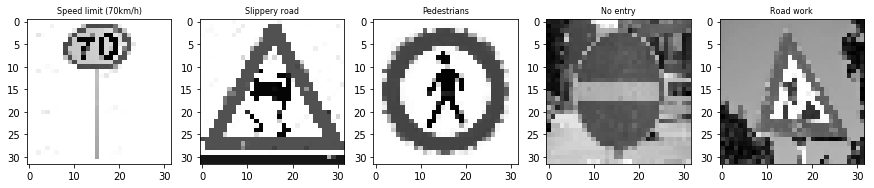

In [22]:
# Normalize
# Convert to grayscale
X_new_gray = np.mean(X_new,axis=-1).reshape(-1,32,32,1)
print("X_new_gray:",X_new_gray.shape)
X_new_normalized = X_new_gray/255
print()
# Visualize
fig, ax = plt.subplots(1,5, figsize=(15, 6))

for i in range(5):
    ax[i].imshow(X_new_normalized[i].squeeze(),cmap='gray')
    ax[i].set_title(signs['SignName'][y_new_labels[i]],fontsize=8)    
plt.savefig('./output/web_images.jpg',bbox_inches = 'tight', pad_inches = 0)

### Predict the Sign Type for Each Image and Find Accuracy

In [23]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saved_graph = tf.train.import_meta_graph('./lenet_mod.meta')
    saved_graph.restore(sess, "./lenet_mod")
    internet_accuracy = evaluate(X_new_normalized, y_new_labels)
    print("Additional Image Test Accuracy = {:.3f}".format(internet_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet_mod
Additional Image Test Accuracy = 0.400


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [31]:
softmax = tf.nn.softmax(logits)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('./lenet_mod.meta')
    saver3.restore(sess, "./lenet_mod")
    probabilities = sess.run(softmax, feed_dict={x: X_new_normalized, y: y_new_labels, keep_prob: 1.0})
    result_top_five = sess.run(tf.nn.top_k(probabilities, k=5))
    print(result_top_five)
    
print('GroundTruth: ',y_new_labels)

INFO:tensorflow:Restoring parameters from ./lenet_mod
TopKV2(values=array([[  5.68378150e-01,   2.29687467e-01,   1.72620669e-01,
          2.05079950e-02,   4.13777446e-03],
       [  9.99371350e-01,   2.41140224e-04,   1.92313732e-04,
          1.89768194e-04,   1.65519373e-06],
       [  9.54150975e-01,   3.95272262e-02,   4.81002731e-03,
          1.34040369e-03,   1.70177722e-04],
       [  1.00000000e+00,   3.07106380e-16,   3.06713711e-19,
          2.72498174e-20,   2.09481934e-23],
       [  9.99996305e-01,   2.35562629e-06,   1.02180149e-06,
          1.49431941e-07,   8.77318058e-08]], dtype=float32), indices=array([[33, 15, 13, 35, 18],
       [19, 40, 37, 11, 10],
       [40, 12,  4,  1, 26],
       [17,  9, 14, 10, 34],
       [25, 24, 22, 31, 29]], dtype=int32))
GroundTruth:  [ 4 23 27 17 25]


## Visualize the Neural Network's State with Test Images

In [34]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, keep_prob:1.0})
    featuremaps = activation.shape[3]
    print('activation',featuremaps)
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from ./lenet_mod
activation 6
activation 16


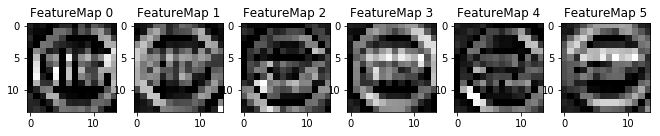

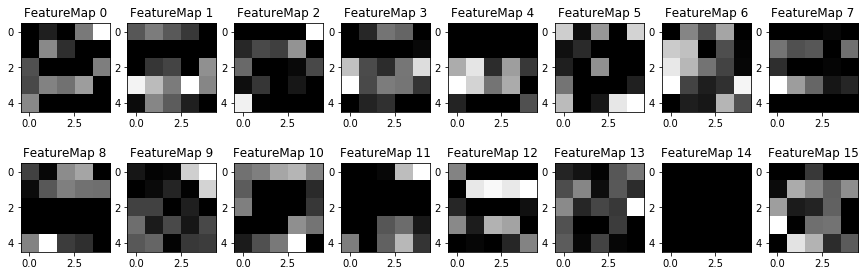

In [39]:
with tf.Session() as sess:

    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    conv1 = sess.graph.get_tensor_by_name('conv1:0')
    outputFeatureMap(X_train_normalized,conv1, activation_min=-1, activation_max=-1, plt_num=1)
    
    conv2 = sess.graph.get_tensor_by_name('conv2:0')
    outputFeatureMap(X_train_normalized,conv2, activation_min=-1, activation_max=-1, plt_num=2)
    
#     conv3 = sess.graph.get_tensor_by_name('conv3:0')
#     outputFeatureMap(X_train_normalized,conv3, activation_min=-1, activation_max=-1, plt_num=3)